In [1]:
import gc
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from craft_text_detector import Craft
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time

/Users/chigi/Developer/cd_ocr_code_runner/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

/Users/chigi/Developer/cd_ocr_code_runner/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def read(image_path):
    craft = Craft(output_dir=None, crop_type="box", cuda=False)
    image = cv2.imread(image_path)
    result = craft.detect_text(image_path)
    boxes = result["boxes"]
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    texts = []
    for box in boxes:
        crop = pil_image.crop([box[0][0], box[0][1], box[2][0], box[2][1]])
        pixel_values = processor(crop, return_tensors="pt").pixel_values
        with torch.no_grad():
            generated_ids = model.generate(pixel_values)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        texts.append(text)
    return texts

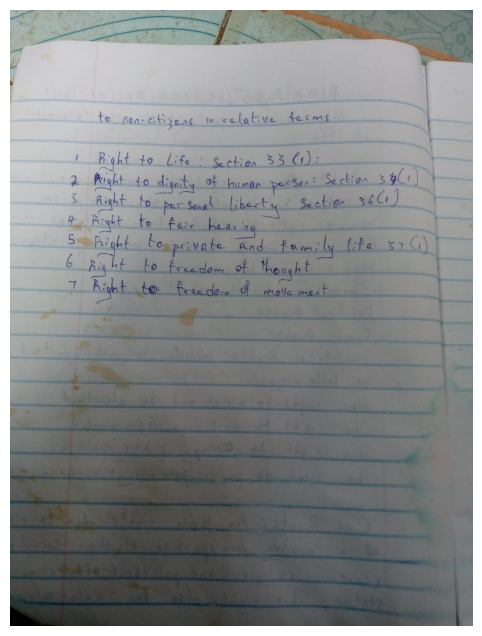

In [4]:
image_path = "test/eng_AF_022.jpg"
img = Image.open(image_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  
plt.show()

In [5]:
start_time = time.time()
texts = read(image_path)
text_data = " ".join(texts)
end_time = time.time()
time_difference = end_time - start_time
print(f"Time: {time_difference} seconds")
print("Data\n")
print(text_data)
gc.collect()
torch.cuda.empty_cache()

/Users/chigi/Developer/cd_ocr_code_runner/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chigi/Developer/cd_ocr_code_runner/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/chigi/Developer/cd_ocr_code_runner/craft_text_detector/craft_utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more de

Time: 32.675766944885254 seconds
Data

to non-citizens in relative terms Right to Life, Section 33 (000 Right to dignity of human personal Section 3 ( H. 1, station 36(1 ) right to personal liberty Right to Fair hearing 5. top Private and family life is? fright. right to freedom of thought height too freedom. moldsement.
